# OilyGiant mining company

Our task is to find the best place for a new well.
Steps to choose the location:
- Collect the oil well parameters in the selected region: oil quality and volume of reserves;
- Build a model for predicting the volume of reserves in the new wells;
- Pick the oil wells with the highest estimated values;
- Pick the region with the highest total profit for the selected oil wells.

Data description
Geological exploration data for the three regions are stored in files:
- geo_data_0.csv 
- geo_data_1.csv
- geo_data_2.csv 
- id — unique oil well identifier
- f0, f1, f2 — three features of points (their specific meaning is unimportant, but the features themselves are significant)
- product — volume of reserves in the oil well (thousand barrels).

# 1.Download and prepare the data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# const random_state 
RANDOM_STATE = 12345

# Silence SettingWithCopyWarning 
pd.options.mode.chained_assignment = None


In [3]:
#Read csv file
region_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv') 
region_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
region_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')


In [4]:
#General information
region_0.info()
region_0.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
25962,xW0nZ,-0.477455,0.537646,0.262794,90.129893
14530,eb9Um,0.951282,0.401446,3.661015,70.812957
89403,WuLEU,2.026615,0.361617,0.670020,91.560466
81444,PqtPv,1.008011,0.229291,0.366191,28.379713
19308,75RD9,0.887361,-0.694434,1.801716,160.610155
85777,Ou7un,0.454052,0.865615,8.119271,153.274800
6314,vI3Iw,1.536540,-0.416363,-1.187327,87.821311
99733,au949,-0.740456,0.814690,2.818758,14.687599
8442,6Ldzq,0.811790,-0.599559,-1.426965,136.502024
68379,EzcgT,0.455865,-0.158673,5.123882,79.797697


In [5]:
#General information
region_1.info()
region_1.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
19186,iz07W,-4.005106,-11.623063,2.999778,84.038886
38444,4XoQ4,3.279759,-10.991208,0.994810,30.132364
14267,rUZdy,14.464563,6.174871,5.004380,134.766305
12580,zuEQp,9.609117,-0.652356,1.001286,26.953261
73073,oucbl,-4.787223,-2.604776,3.998551,110.992147
14842,maQ8B,12.617756,-7.079880,0.002986,0.000000
57334,Uin2a,-17.966255,0.847609,3.002767,84.038886
38680,p58yQ,6.140492,-10.764543,-0.000174,0.000000
2299,Edzw7,12.650460,-7.907149,0.993054,26.953261
70025,6Ba6z,1.827751,-11.051957,2.995869,84.038886


In [6]:
#General information
region_2.info()
region_2.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
86500,Jeh7X,-0.186684,-1.805224,1.166428,4.620797
45306,zI2PI,-1.668463,1.321681,10.017476,171.651845
57322,b95iC,-2.910862,1.701288,7.415548,151.915709
12196,iyhHi,0.140889,1.938911,-2.197602,18.759872
35076,ve936,4.117534,2.115825,2.333998,87.591388
96649,5l7Gj,-0.310101,-1.956450,6.267629,129.129526
9483,SPPJG,2.641431,-0.523410,10.107448,135.493514
91306,rYGB5,-1.588520,-0.356861,7.184121,124.579520
13027,VKLgl,-0.306155,-0.206000,1.954437,5.160975
17577,h4dY1,-0.761982,0.819385,6.771134,122.388344


In [7]:
# There are id's with more then 1 row
# We don't know why and which one of then is correct
#we'll delete those id's
region_0 = region_0[region_0.groupby("id")["id"].transform(len)< 2]
region_1 = region_1[region_1.groupby("id")["id"].transform(len)< 2]
region_2 = region_2[region_2.groupby("id")["id"].transform(len)< 2]


In [8]:
#Check for duplicates
region_0.duplicated().sum()

0

In [9]:
#Check for duplicates
region_1.duplicated().sum()

0

In [10]:
#Check for duplicates
region_2.duplicated().sum()

0

In [11]:
# Drop features that not required
region_0.drop(['id'], axis=1, inplace=True)
region_1.drop(['id'], axis=1, inplace=True)
region_2.drop(['id'], axis=1, inplace=True)

## Conclusion

 - There are no missing values.
 - There are no duplicates rows.
 - There are id's with more then 1 row. 
    region_0 - 10 duplicated rows(20 rows in total)
    region_1 - 4 duplicated rows(8 rows in total)
    region_2 - 4 duplicated rows(8 rows in total)
    We don't know why and which one of then is correct, and they are very few
    we have 100,000 rows for each region 
    we'll delete those id's.

#  2.Train and test the model for each region

In [12]:
def data_split(region):
    target = region['product']
    features = region.drop(['product'], axis=1)

    # Split data into train and validation
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=RANDOM_STATE)
    return (features_train,features_valid, target_train, target_valid)

In [13]:

def data_scaling(features_train, features_valid):
   
    # Standardize the numeric features
    scaler = StandardScaler()

    #numeric fields to scale
    numeric = ['f0','f1','f2']

    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    return (features_train,features_valid)


In [14]:
# execute LinearRegression model
def Linear_Regression_model(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    # Calculate predicted_valid nean value
    predicted_valid_mean = predicted_valid.mean()
    # Calculate mse value
    mse = mean_squared_error(target_valid, predicted_valid)
    # Calculate rmse
    rmse = mse ** 0.5
    return rmse, predicted_valid_mean, predicted_valid

In [15]:
# Execute for region_0
features_train_0,features_valid_0, target_train_0, target_valid_0 = data_split(region_0)
features_train_0,features_valid_0 = data_scaling(features_train_0, features_valid_0)
rmse_region_0, predicted_valid_mean_region_0, predicted_valid_0 = \
                                Linear_Regression_model(features_train_0, features_valid_0, target_train_0, target_valid_0)
print('region_0')
print('RMSE=', rmse_region_0)
print('mean=', predicted_valid_mean_region_0)

region_0
RMSE= 37.716904960382735
mean= 92.42384109947358


In [16]:
# Execute for region_1
features_train_1,features_valid_1, target_train_1, target_valid_1 = data_split(region_1)
features_train_1,features_valid_1 = data_scaling(features_train_1, features_valid_1)
rmse_region_1, predicted_valid_mean_region_1,predicted_valid_1 = \
                                Linear_Regression_model(features_train_1, features_valid_1, target_train_1, target_valid_1)
print('region_1')
print('RMSE=', rmse_region_1)
print('mean=', predicted_valid_mean_region_1)

region_1
RMSE= 0.8914901390348529
mean= 68.98311857983121


In [17]:
features_train_2,features_valid_2, target_train_2, target_valid_2 = data_split(region_2)
features_train_2,features_valid_2 = data_scaling(features_train_2, features_valid_2)
rmse_region_2, predicted_valid_mean_region_2, predicted_valid_2 = \
                                Linear_Regression_model(features_train_2, features_valid_2, target_train_2, target_valid_2)
print('region_2')
print('RMSE=', rmse_region_2)
print('mean=', predicted_valid_mean_region_2)

region_2
RMSE= 39.975543264382345
mean= 95.11622302076478


In [18]:
# initialize list of lists
data = [[rmse_region_0,predicted_valid_mean_region_0 ],
        [rmse_region_1,predicted_valid_mean_region_1 ],
        [rmse_region_2,predicted_valid_mean_region_2 ]]
 
# Create the pandas DataFrame
result = pd.DataFrame(data, columns = ['RMSE', 'mean'])

# print dataframe.
result

,RMSE,mean
0,37.716905,92.423841
1,0.891490,68.983119
2,39.975543,95.116223


##  Conclusion

- region_1 has the lowest RMSE 
- RMSE= 0.8914901390348529
- mean= 68.98311857983121
- RMSE is lower than the mean so we have a good model 


# 3.Prepare for profit calculation

In [19]:
budget_dev_oil_well = 500000
barrel_revenue = 4.5
one_unit_product_revenue = 4500


In [20]:
#The volume of reserves sufficient for developing a new well without losses
new_will_min_volume = budget_dev_oil_well / one_unit_product_revenue
print('The volume of reserves sufficient for developing a new well without losses is ',new_will_min_volume)

The volume of reserves sufficient for developing a new well without losses is  111.11111111111111


In [21]:
region_0_mean = region_0['product'].mean()
region_1_mean = region_1['product'].mean()
region_2_mean = region_2['product'].mean()
print('region_0 mean', region_0_mean)
print('region_1 mean', region_1_mean)
print('region_2 mean', region_2_mean)

region_0 mean 92.49916597893447
region_1 mean 68.82414772665173
region_2 mean 94.99876686768079


## conclusion

- The volume of reserves sufficient for developing a new well without losses is  111.11
- region_0 mean valume = 92.49916597893447
- region_1 mean valume = 68.82414772665173
- region_2 mean valume = 94.99876686768079

- As we can see the neam value for all regons is lower then the min volume of reserves sufficient for developing a new well    without losses.<br><br>
<b>conclusion</b> - We need to pick the best oil wells in each region

# 4.Write a function to calculate profit from a set of selected oil wells and model predictions

In [22]:
# Calculate profit for a region
def region_profit(predicted, target):
    #Create series from predicted_valid 
    predicted_series = pd.Series(predicted, name='predicted',index=target.index) \
                                                                    .sort_values(ascending=False)
    # 200 wells with the highest values of predictions
    highest_predict_wells = target[predicted_series[:200].index]

    # Sum 200 wells with the highest values of predictions
    sum_highest_predict_wells = highest_predict_wells.sum()
    revenue = sum_highest_predict_wells *one_unit_product_revenue
    profit = revenue - (200 * budget_dev_oil_well)

    return profit

In [23]:
region_0_profit =region_profit(predicted_valid_0, target_valid_0)
region_1_profit =region_profit(predicted_valid_1, target_valid_1)
region_2_profit =region_profit(predicted_valid_2, target_valid_2)

print('region 0 profit=', region_0_profit)
print('region 1 profit=', region_1_profit)
print('region 2 profit=', region_2_profit)

region 0 profit= 31360260.5665586
region 1 profit= 24150866.966815114
region 2 profit= 24659457.920122653


## Conclution 

<b>region 0 as the highest profit </b>

# 5.Calculate risks and profit for each region

In [24]:

def bootstrap_calc(predicted,target):
     #Create series from predicted_valid 
    predicted = pd.Series(predicted, name='predicted',index=target.index)

    state = np.random.RandomState(12345)    
    values = []
    #Number of samples
    num_samples = 1000
    for i in range(num_samples): 
        #Create sample of 500 points
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        #Get the predicted values of the target points
        probs_subsample = predicted[target_subsample.index]
        #Calculte profit
        profit_subsample = region_profit(probs_subsample, target_subsample)
        #Summerize subsumple profit
        values.append(profit_subsample)

    values = pd.Series(values)
    lower =values.quantile(0.025)
    upper =values.quantile(0.975)

    mean = values.mean()
    
    return values, mean, upper, lower
    

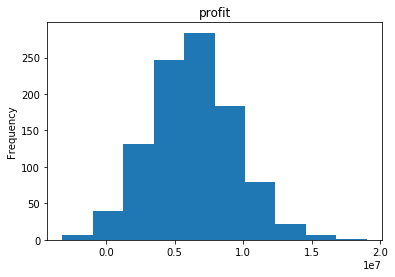

In [25]:
values_region_0, mean_region_0, upper_region_0, lower_region_0 =bootstrap_calc(predicted_valid_0, target_valid_0)
values_region_0.plot(kind='hist',title='profit');

In [27]:
print('region 0')
print('mean : {}'.format(mean_region_0))
print('95% confidence interval: {} , {}'.format(lower_region_0, upper_region_0))
risk_probability_region_0 = (values_region_0 <0).sum() / values_region_0.count() 
print('risk of losses is:{:,.2%}'.format(risk_probability_region_0))

region 0
mean : 6329210.984851676
95% confidence interval: 549998.1921787062 , 12849098.546222579
risk of losses is:2.00%


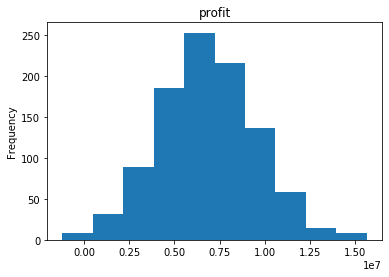

In [28]:
values_region_1, mean_region_1,upper_region_1,lower_region_1 =bootstrap_calc(predicted_valid_1, target_valid_1)

values_region_1.plot(kind='hist',title='profit')

In [29]:
print('region 1')
print('mean : {}'.format(mean_region_1))
print('95% confidence interval: {} , {}'.format(lower_region_1, upper_region_1))
risk_probability_region_1 = (values_region_1 <0).sum() / values_region_1.count() 
print('risk of losses is:{:,.2%}'.format(risk_probability_region_1))

region 1
mean : 6836507.782372232
95% confidence interval: 1761041.827247675 , 12000844.859101081
risk of losses is:0.70%


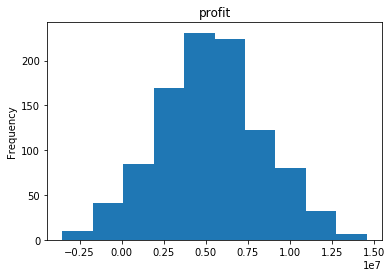

In [30]:
values_region_2, mean_region_2, upper_region_2, lower_region_2 =bootstrap_calc(predicted_valid_2, target_valid_2)
values_region_2.plot(kind='hist',title='profit');

In [31]:
print('region 2')
print('mean : {}'.format(mean_region_2))
print('95% confidence interval: {} , {}'.format(lower_region_2, upper_region_2))
risk_probability_region_2 = (values_region_2 <0).sum() / values_region_2.count() 
print('risk of losses is:{:,.2%}'.format(risk_probability_region_2))

region 2
mean : 5290364.667416241
95% confidence interval: -635691.3093939188 , 11644733.641825799
risk of losses is:4.40%


In [32]:
# initialize list of lists
data = [[mean_region_0,lower_region_0,upper_region_0,risk_probability_region_0 *100 ],
        [mean_region_1,lower_region_1,upper_region_1,risk_probability_region_1 *100 ],
        [mean_region_2,lower_region_2,upper_region_2,risk_probability_region_2 *100 ]]
 
# Create the pandas DataFrame
result = pd.DataFrame(data, columns = ['mean', 'lower','upper','risk'])
result['mean'] = result['mean'].astype('int64')
result['lower'] = result['lower'].astype('int64') 
result['upper'] = result['upper'].astype('int64') 
# print dataframe.
result

,mean,lower,upper,risk
0,6329210,549998,12849098,2.0
1,6836507,1761041,12000844,0.7
2,5290364,-635691,11644733,4.4


## Conclusion

- region 1 has the hightest mean value 
- region 1 confidence interval is the best one. has  the highest value in  'lower'  and almost the highest value in 'upper'
- region 1 has 0.7% of risk!!!
- <b> The selected region for development of oil wells is region 1</b>